In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    
    # CMIP data       
    cmip_sst = torch.load("cmip_sst_data.pt")  ## 56156, 12, 24, 72
    cmip_t300 = torch.load("cmip_t300_data.pt")
    cmip_ua = torch.load("cmip_ua_data.pt")
    cmip_va = torch.load("cmip_va_data.pt")
    cmip_label = torch.load("cmip_label.pt")

    # SODA data    
    soda_data = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    soda_label = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    soda_sst = soda_data['sst'][:, :12].values.astype('float32')  # (100, 12, 24, 72)
    soda_t300 = soda_data['t300'][:, :12].values.astype('float32')
    soda_ua = soda_data['ua'][:, :12].values.astype('float32')
    soda_va = soda_data['va'][:, :12].values.astype('float32')
    soda_label = soda_label['nino'][:, 12:36].values.astype('float32')
    
    soda_sst = np.nan_to_num(soda_sst) # trans nan to 0
    soda_t300 = np.nan_to_num(soda_t300)
    soda_ua = np.nan_to_num(soda_ua)
    soda_va = np.nan_to_num(soda_va)

    dict_cmip = {
        'sst':cmip_sst,
        't300':cmip_t300,
        'ua':cmip_ua,
        'va': cmip_va,
        'label': cmip_label}
    dict_soda = {
        'sst':soda_sst,
        't300':soda_t300,
        'ua':soda_ua,
        'va': soda_va,
        'label': soda_label}
    
    cmip_dataset = EarthDataSet(dict_cmip)
    soda_dataset = EarthDataSet(dict_soda)
    
    train_1, valid_1 = random_split(cmip_dataset, [4545, 100])
    train_2, valid_2 = random_split(soda_dataset, [0, 100])
    
    train_dataset = train_1 
    valid_dataset = valid_1
    valid_dataset_2 = valid_2
    
    print('Train samples: {}, Valid1 samples: {}, Valid2 samples: {}'.format(len(train_dataset), len(valid_dataset), len(valid_dataset_2)))
    
    return train_dataset, valid_dataset, valid_dataset_2

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset, valid_dataset_2 = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
valid_loader_2 = DataLoader(valid_dataset_2, batch_size=32, shuffle=False)

Train samples: 4545, Valid1 samples: 100, Valid2 samples: 100


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs, log_interval=20):
    best_score = -99
    loss_epoch = []
    score_epoch = []
    score_epoch_2 = []
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    best_score = score
    
    y_true_2, y_pred_2 = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader_2):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred_2.append(preds.cpu().detach().numpy())
        y_true_2.append(label.cpu().detach().numpy())

    y_true_2 = np.concatenate(y_true_2, axis=0)
    y_pred_2 = np.concatenate(y_pred_2, axis=0)
    x_month = np.arange(24)
    score_2 = eval_score(y_true_2, y_pred_2)
    print('Epoch: {}, Valid Score: {}, Valid Score 2: {}\n'.format(epoch+1,score,score_2))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):   
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%log_interval == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds.cpu().detach().numpy())
            y_true.append(label.cpu().detach().numpy())

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        score_epoch.append(score)
        
        y_true_2, y_pred_2 = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader_2):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred_2.append(preds.cpu().detach().numpy())
            y_true_2.append(label.cpu().detach().numpy())

        y_true_2 = np.concatenate(y_true_2, axis=0)
        y_pred_2 = np.concatenate(y_pred_2, axis=0)
        x_month = np.arange(24)
        score_2 = eval_score(y_true_2, y_pred_2)
        score_epoch_2.append(score_2)
        print('Epoch: {}, Valid Score: {}, Valid Score 2: {}\n'.format(epoch+1,score,score_2))    
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(10):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        j = 0
        for i in range(10, 23):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true_2[j],color='red')
            plt.plot(x_month, y_pred_2[j],color='blue')
            j += 1
        plt.subplot(5,5,24)
        plt.plot(np.arange(len(loss_epoch))[:20],loss_epoch[-20:])
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(score_epoch)),score_epoch)
        plt.plot(np.arange(len(score_epoch)),score_epoch_2)
        plt.tight_layout()
        plt.show()
        
    max_score = max(score_epoch)
    max_epoch = score_epoch.index(max_score) + 1
    print("max score: {} at eopch {}".format(max_score, max_epoch))
    max_score_2 = max(score_epoch_2)
    max_epoch_2 = score_epoch_2.index(max_score_2) + 1
    print("max score 2: {} at eopch {}".format(max_score_2, max_epoch_2))

In [23]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv = nn.Sequential(nn.Conv3d(in_channels=4, out_channels=4, kernel_size=(3,4,8)),
                                  nn.BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True)) 
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 64))
        self.linear = nn.Linear(64, 24)

    def forward(self, sst, t300, ua, va):
        
        x = torch.stack([sst, t300, ua, va], dim=1) # batch * 4 * 12 * 24 * 72
        bs = x.shape[0]
        x = self.conv(x).view(bs, 4, -1)
        x = self.avgpool(x).view(bs, -1)
        x = self.linear(x)
        return x

In [24]:
'''



'''

'\n\n\n\n'

In [25]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

gpu_ids = [i for i in range(int(torch.cuda.device_count()))]
model = torch.nn.DataParallel(model.to("cuda:0"), device_ids=gpu_ids)
loss_fn = loss_fn.to(device)

In [26]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

DataParallel : all params: 0.003108M


In [27]:
model

DataParallel(
  (module): CNN_Model(
    (conv): Sequential(
      (0): Conv3d(4, 4, kernel_size=(3, 4, 8), stride=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 64))
    (linear): Linear(in_features=64, out_features=24, bias=True)
  )
)

acskill_socre:44.79407834850541, rmse_score:16.19199741620411
acskill_socre:27.563757064187257, rmse_score:17.102244480073235
Epoch: 0, Valid Score: 28.6020809323013, Valid Score 2: 10.461512584114022

Step: 0, Train Loss: 0.3587537407875061
Step: 20, Train Loss: 0.6746570467948914
Step: 40, Train Loss: 0.5085145831108093
Step: 60, Train Loss: 0.4520527720451355
Step: 80, Train Loss: 0.42237839102745056
Step: 100, Train Loss: 0.5320489406585693
Step: 120, Train Loss: 0.48678478598594666
Step: 140, Train Loss: 0.5147240161895752
Epoch: 1, Train loss: 0.5049453750773744
acskill_socre:45.3202751829521, rmse_score:16.2270715097159
acskill_socre:27.139964674611022, rmse_score:17.191917303685848
Epoch: 1, Valid Score: 29.093203673236204, Valid Score 2: 9.948047370925174

Model saved successfully


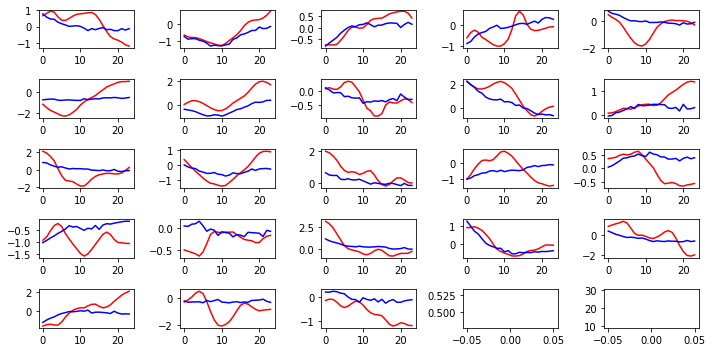

Step: 0, Train Loss: 0.4241902530193329
Step: 20, Train Loss: 0.48545604944229126
Step: 40, Train Loss: 0.487338125705719
Step: 60, Train Loss: 0.4082222878932953
Step: 80, Train Loss: 0.41999074816703796
Step: 100, Train Loss: 0.4587576389312744
Step: 120, Train Loss: 0.49454498291015625
Step: 140, Train Loss: 0.5523817539215088
Epoch: 2, Train loss: 0.49916147862697813
acskill_socre:44.751596171041555, rmse_score:16.232607381363998
acskill_socre:27.92428553059996, rmse_score:17.076827774322965
Epoch: 2, Valid Score: 28.518988789677557, Valid Score 2: 10.847457756276995



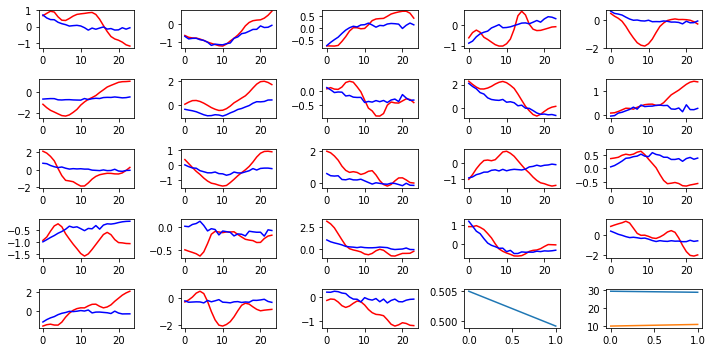

Step: 0, Train Loss: 0.5665647387504578
Step: 20, Train Loss: 0.4832228422164917
Step: 40, Train Loss: 0.5515782237052917
Step: 60, Train Loss: 0.5794160962104797
Step: 80, Train Loss: 0.5357500314712524
Step: 100, Train Loss: 0.45285940170288086
Step: 120, Train Loss: 0.3499296307563782
Step: 140, Train Loss: 0.49047955870628357
Epoch: 3, Train loss: 0.4994420050741076
acskill_socre:45.06022878271247, rmse_score:16.27594083261776
acskill_socre:27.644330793931193, rmse_score:17.12413378237825
Epoch: 3, Valid Score: 28.78428795009471, Valid Score 2: 10.520197011552941



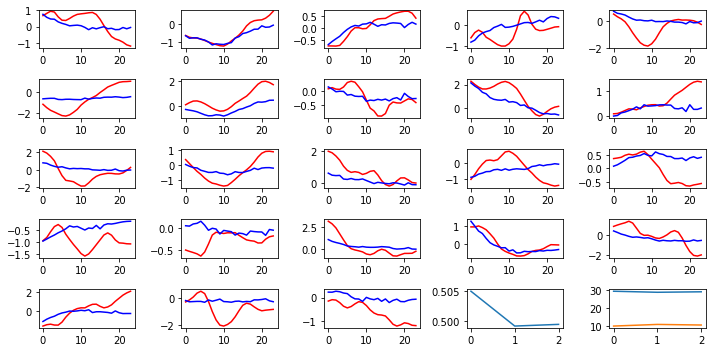

Step: 0, Train Loss: 0.757264256477356
Step: 20, Train Loss: 0.4725475311279297
Step: 40, Train Loss: 0.5078656077384949
Step: 60, Train Loss: 0.5126822590827942
Step: 80, Train Loss: 0.5185773372650146
Step: 100, Train Loss: 0.4346974790096283
Step: 120, Train Loss: 0.5168589353561401
Step: 140, Train Loss: 0.5153399705886841
Epoch: 4, Train loss: 0.4960187244248557
acskill_socre:45.2858595101227, rmse_score:16.218719574521636
acskill_socre:27.30211970975347, rmse_score:17.13991960700561
Epoch: 4, Valid Score: 29.067139935601062, Valid Score 2: 10.16220010274786



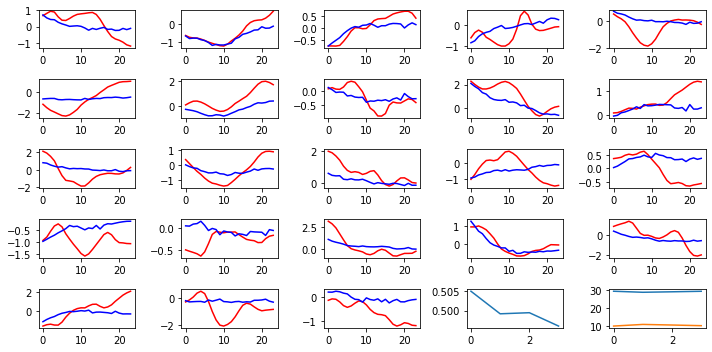

Step: 0, Train Loss: 0.4097856879234314
Step: 20, Train Loss: 0.4395790100097656
Step: 40, Train Loss: 0.40864238142967224
Step: 60, Train Loss: 0.41477808356285095
Step: 80, Train Loss: 0.4335833191871643
Step: 100, Train Loss: 0.4339035451412201
Step: 120, Train Loss: 0.47354909777641296
Step: 140, Train Loss: 0.5836286544799805
Epoch: 5, Train loss: 0.49712422636005427
acskill_socre:44.6395548647876, rmse_score:16.217607124528655
acskill_socre:27.727153651440297, rmse_score:17.07087767037473
Epoch: 5, Valid Score: 28.421947740258943, Valid Score 2: 10.656275981065566



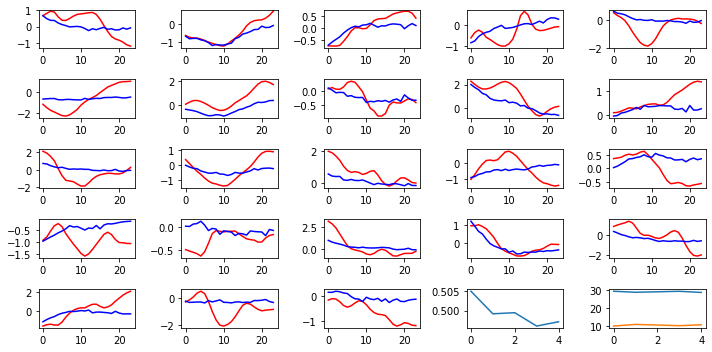

Step: 0, Train Loss: 0.6904599070549011
Step: 20, Train Loss: 0.443284273147583
Step: 40, Train Loss: 0.64012211561203
Step: 60, Train Loss: 0.7419657707214355
Step: 80, Train Loss: 0.5298838019371033
Step: 100, Train Loss: 0.4703310430049896
Step: 120, Train Loss: 0.6633776426315308
Step: 140, Train Loss: 0.554295003414154
Epoch: 6, Train loss: 0.5026443888257434
acskill_socre:44.9449667522874, rmse_score:16.229134087746278
acskill_socre:27.642863648587685, rmse_score:17.093711666489348
Epoch: 6, Valid Score: 28.71583266454112, Valid Score 2: 10.549151982098337



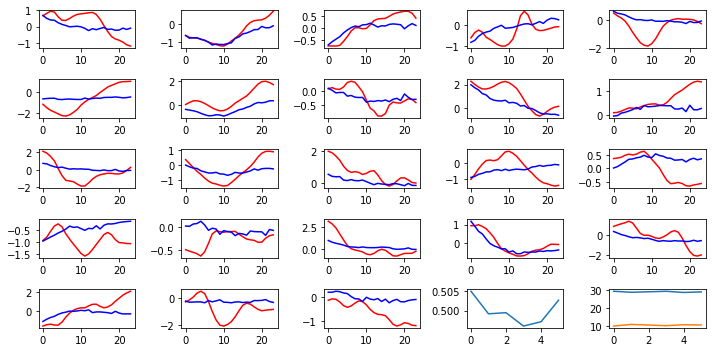

Step: 0, Train Loss: 0.43746551871299744
Step: 20, Train Loss: 0.44871777296066284
Step: 40, Train Loss: 0.6218559741973877
Step: 60, Train Loss: 0.5109039545059204
Step: 80, Train Loss: 0.5481878519058228
Step: 100, Train Loss: 0.5718407034873962
Step: 120, Train Loss: 0.6249707937240601
Step: 140, Train Loss: 0.46702146530151367
Epoch: 7, Train loss: 0.5044312281208438
acskill_socre:45.473052805452035, rmse_score:16.33540893412065
acskill_socre:27.504523855218515, rmse_score:17.205969755819062
Epoch: 7, Valid Score: 29.137643871331385, Valid Score 2: 10.298554099399453

Model saved successfully


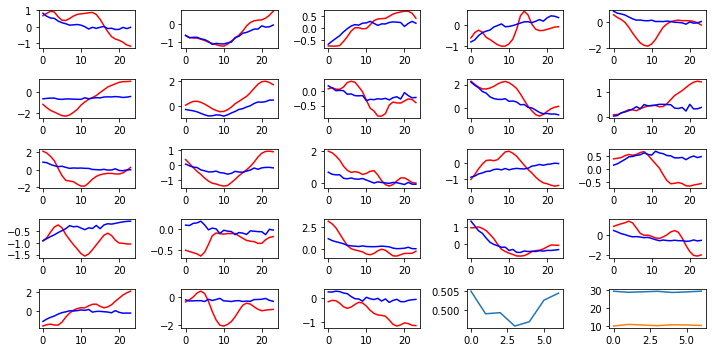

Step: 0, Train Loss: 0.34837064146995544
Step: 20, Train Loss: 0.5072362422943115
Step: 40, Train Loss: 0.4990273416042328
Step: 60, Train Loss: 0.6446993350982666
Step: 80, Train Loss: 0.4524737298488617
Step: 100, Train Loss: 0.46229085326194763
Step: 120, Train Loss: 0.3572406768798828
Step: 140, Train Loss: 0.380648672580719
Epoch: 8, Train loss: 0.49483521522341906
acskill_socre:44.88229566775365, rmse_score:16.178474051391337
acskill_socre:27.61706007947476, rmse_score:17.105282609106883
Epoch: 8, Valid Score: 28.703821616362315, Valid Score 2: 10.511777470367878



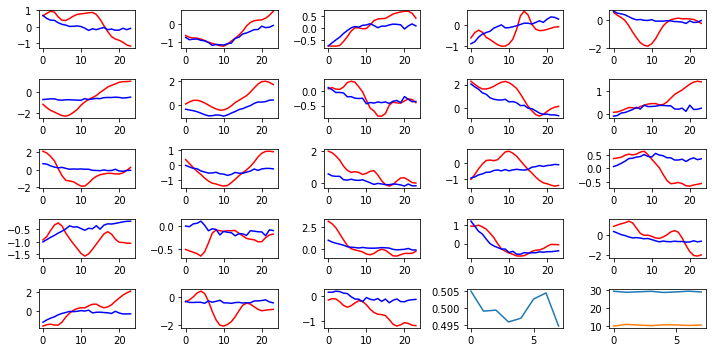

Step: 0, Train Loss: 0.4466981887817383
Step: 20, Train Loss: 0.5728933215141296
Step: 40, Train Loss: 0.3647787570953369
Step: 60, Train Loss: 0.6417534351348877
Step: 80, Train Loss: 0.3820236921310425
Step: 100, Train Loss: 0.3735894560813904
Step: 120, Train Loss: 0.4019542634487152
Step: 140, Train Loss: 0.5240532159805298
Epoch: 9, Train loss: 0.49550846635878504
acskill_socre:45.21436729779529, rmse_score:16.17584213497162
acskill_socre:27.278823292656647, rmse_score:17.17448483873529
Epoch: 9, Valid Score: 29.03852516282367, Valid Score 2: 10.104338453921358



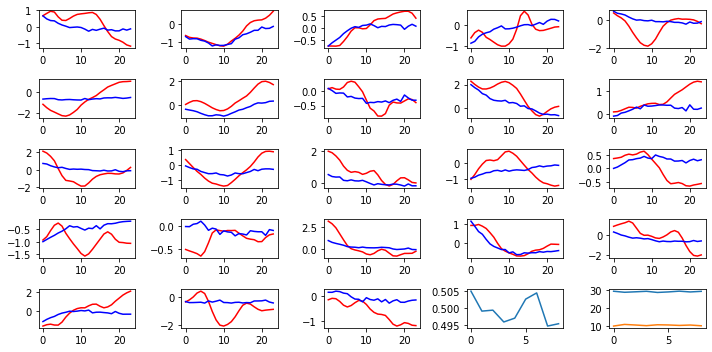

Step: 0, Train Loss: 0.42993825674057007
Step: 20, Train Loss: 0.5186202526092529
Step: 40, Train Loss: 0.637149453163147
Step: 60, Train Loss: 0.5587820410728455
Step: 80, Train Loss: 0.4554842412471771
Step: 100, Train Loss: 0.5714942216873169
Step: 120, Train Loss: 0.5948335528373718
Step: 140, Train Loss: 0.31304270029067993
Epoch: 10, Train loss: 0.5021972852153378
acskill_socre:45.95313371936553, rmse_score:16.168541087960044
acskill_socre:26.891583914290223, rmse_score:17.20616317224066
Epoch: 10, Valid Score: 29.784592631405488, Valid Score 2: 9.685420742049562

Model saved successfully


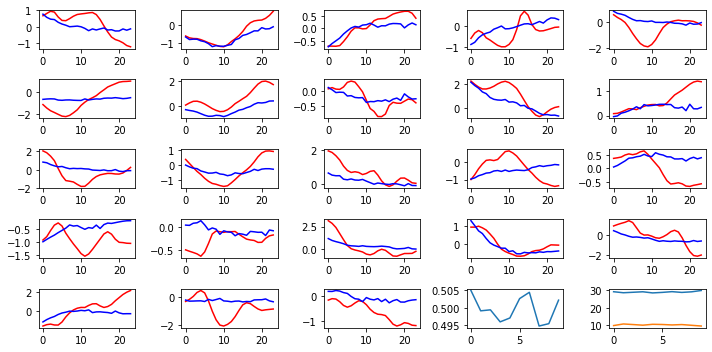

Step: 0, Train Loss: 0.43115612864494324
Step: 20, Train Loss: 0.4568381905555725
Step: 40, Train Loss: 0.4160325229167938
Step: 60, Train Loss: 0.5976622104644775
Step: 80, Train Loss: 0.6082159876823425
Step: 100, Train Loss: 0.7203642725944519
Step: 120, Train Loss: 0.4011557102203369
Step: 140, Train Loss: 0.5121089220046997
Epoch: 11, Train loss: 0.49537272404853283
acskill_socre:45.18425766559051, rmse_score:16.279981415157163
acskill_socre:27.230901879567487, rmse_score:17.20863683184058
Epoch: 11, Valid Score: 28.904276250433345, Valid Score 2: 10.022265047726908



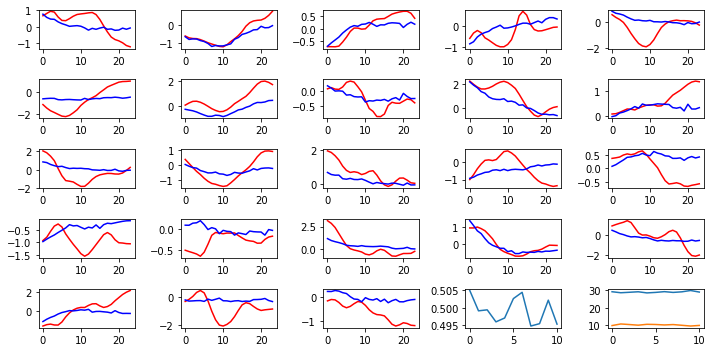

Step: 0, Train Loss: 0.5772455930709839
Step: 20, Train Loss: 0.4607858657836914
Step: 40, Train Loss: 0.45444250106811523
Step: 60, Train Loss: 0.5706493258476257
Step: 80, Train Loss: 0.4793508052825928
Step: 100, Train Loss: 0.5483384132385254
Step: 120, Train Loss: 0.4133908748626709
Step: 140, Train Loss: 0.5089309215545654
Epoch: 12, Train loss: 0.49411232472508104
acskill_socre:45.19371672428912, rmse_score:16.205990840302203
acskill_socre:27.620033797520506, rmse_score:17.101901515941456
Epoch: 12, Valid Score: 28.987725883986915, Valid Score 2: 10.51813228157905



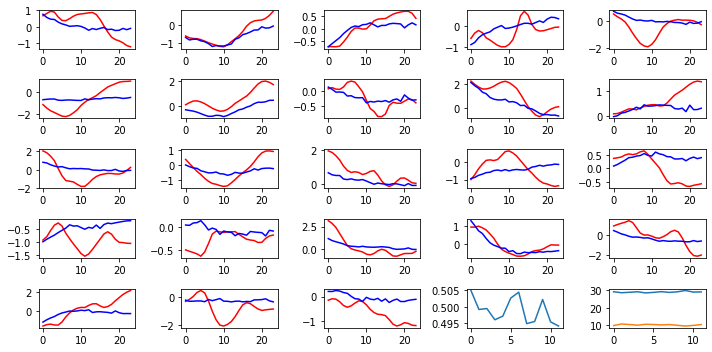

Step: 0, Train Loss: 0.4779934287071228
Step: 20, Train Loss: 0.36443862318992615
Step: 40, Train Loss: 0.40206918120384216
Step: 60, Train Loss: 0.5063228607177734
Step: 80, Train Loss: 0.4682033956050873
Step: 100, Train Loss: 0.5080722570419312
Step: 120, Train Loss: 0.4407559335231781
Step: 140, Train Loss: 0.6037193536758423
Epoch: 13, Train loss: 0.49683841979586996
acskill_socre:45.11384455491237, rmse_score:16.171877445078415
acskill_socre:27.578967822654093, rmse_score:17.11877072480494
Epoch: 13, Valid Score: 28.941967109833953, Valid Score 2: 10.460197097849154



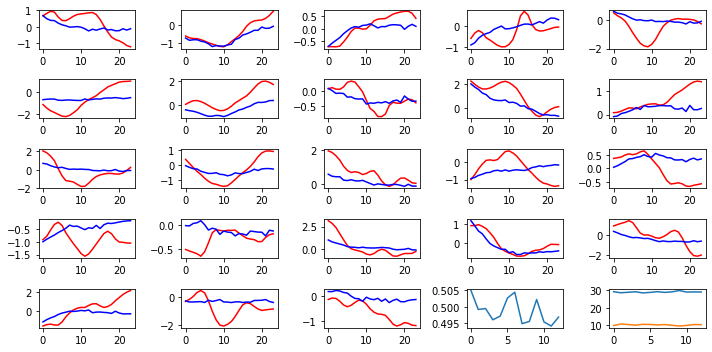

Step: 0, Train Loss: 0.4455340802669525
Step: 20, Train Loss: 0.420798122882843
Step: 40, Train Loss: 0.518516480922699
Step: 60, Train Loss: 0.5195770263671875
Step: 80, Train Loss: 0.7571556568145752
Step: 100, Train Loss: 0.6175028681755066
Step: 120, Train Loss: 0.6139453649520874
Step: 140, Train Loss: 0.5423321723937988
Epoch: 14, Train loss: 0.49475311951620593
acskill_socre:45.35458025010835, rmse_score:16.229119301517237
acskill_socre:27.27517733985177, rmse_score:17.240140090265996
Epoch: 14, Valid Score: 29.125460948591112, Valid Score 2: 10.035037249585773



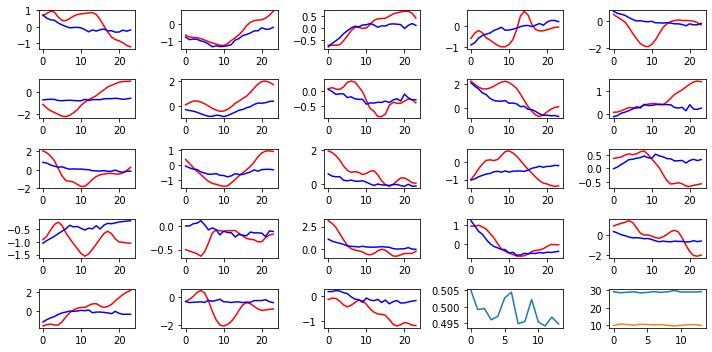

Step: 0, Train Loss: 0.463674396276474
Step: 20, Train Loss: 0.46459588408470154
Step: 40, Train Loss: 0.6100870966911316
Step: 60, Train Loss: 0.4650214612483978
Step: 80, Train Loss: 0.5575151443481445
Step: 100, Train Loss: 0.4842093586921692
Step: 120, Train Loss: 0.4462779760360718
Step: 140, Train Loss: 0.3827509582042694
Epoch: 15, Train loss: 0.4950764925329835
acskill_socre:45.09314561083933, rmse_score:16.19479637059078
acskill_socre:27.655853353336767, rmse_score:17.123778644086265
Epoch: 15, Valid Score: 28.89834924024855, Valid Score 2: 10.532074709250502



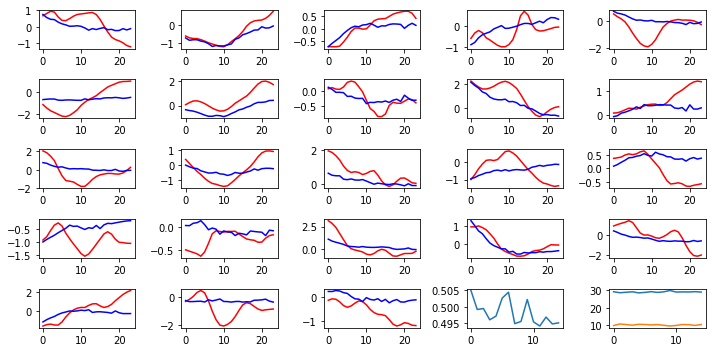

Step: 0, Train Loss: 0.5724008679389954
Step: 20, Train Loss: 0.5132558345794678
Step: 40, Train Loss: 0.39736825227737427
Step: 60, Train Loss: 0.477181613445282
Step: 80, Train Loss: 0.6073070168495178
Step: 100, Train Loss: 0.35038813948631287
Step: 120, Train Loss: 0.38871055841445923
Step: 140, Train Loss: 0.445368230342865
Epoch: 16, Train loss: 0.4958301820121445
acskill_socre:45.098681487717535, rmse_score:16.21209223888249
acskill_socre:27.75085299321846, rmse_score:17.097419406977746
Epoch: 16, Valid Score: 28.886589248835044, Valid Score 2: 10.653433586240713



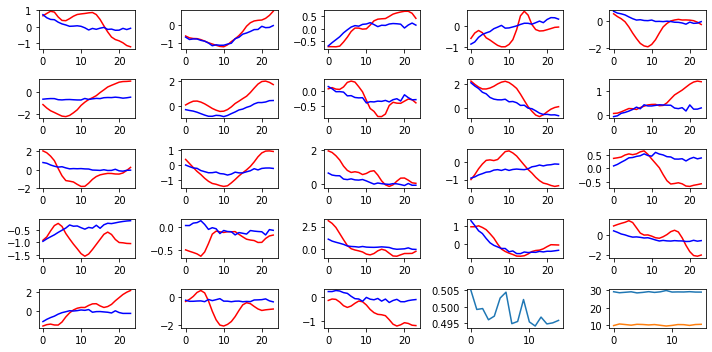

Step: 0, Train Loss: 0.504382848739624
Step: 20, Train Loss: 0.6168625950813293
Step: 40, Train Loss: 0.47042638063430786
Step: 60, Train Loss: 0.4321129322052002
Step: 80, Train Loss: 0.5947262644767761
Step: 100, Train Loss: 0.363592267036438
Step: 120, Train Loss: 0.37271326780319214
Step: 140, Train Loss: 0.4707651138305664
Epoch: 17, Train loss: 0.49408867100735643
acskill_socre:45.43672149450741, rmse_score:16.200517206193613
acskill_socre:27.208651080161495, rmse_score:17.199387476136128
Epoch: 17, Valid Score: 29.236204288313797, Valid Score 2: 10.009263604025367



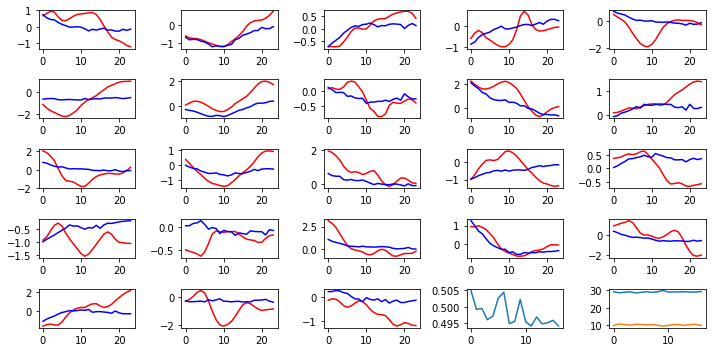

Step: 0, Train Loss: 0.6206545829772949
Step: 20, Train Loss: 0.4438776969909668
Step: 40, Train Loss: 0.589025616645813
Step: 60, Train Loss: 0.38271498680114746
Step: 80, Train Loss: 0.5366888046264648
Step: 100, Train Loss: 0.4301609992980957
Step: 120, Train Loss: 0.4431757926940918
Step: 140, Train Loss: 0.553938627243042
Epoch: 18, Train loss: 0.4934612530303168
acskill_socre:45.00748584379594, rmse_score:16.19387908448539
acskill_socre:27.982116904322687, rmse_score:17.087743336476958
Epoch: 18, Valid Score: 28.813606759310552, Valid Score 2: 10.89437356784573



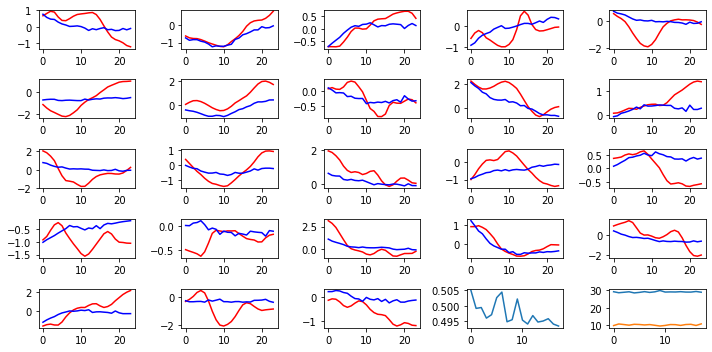

Step: 0, Train Loss: 0.37142500281333923
Step: 20, Train Loss: 0.31762948632240295
Step: 40, Train Loss: 0.6527382135391235
Step: 60, Train Loss: 0.4925912320613861
Step: 80, Train Loss: 0.7247099280357361
Step: 100, Train Loss: 0.6515021324157715
Step: 120, Train Loss: 0.5289222598075867
Step: 140, Train Loss: 0.5516937375068665
Epoch: 19, Train loss: 0.4976336899754051
acskill_socre:45.107422711284855, rmse_score:16.207718155233444
acskill_socre:27.755607270122955, rmse_score:17.119621044582757
Epoch: 19, Valid Score: 28.89970455605141, Valid Score 2: 10.635986225540197



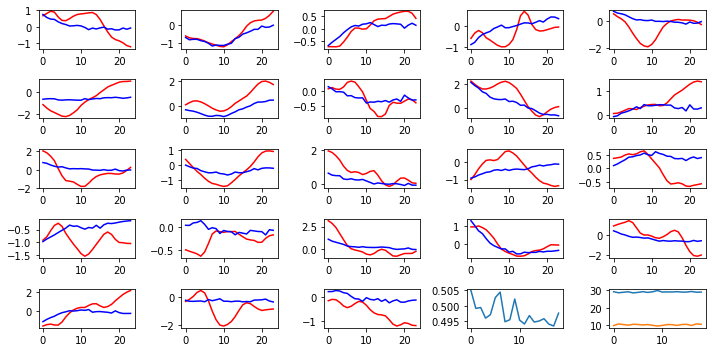

Step: 0, Train Loss: 0.32588621973991394
Step: 20, Train Loss: 0.5645157694816589
Step: 40, Train Loss: 0.5660520792007446
Step: 60, Train Loss: 0.45490020513534546
Step: 80, Train Loss: 0.6336538195610046
Step: 100, Train Loss: 0.4403986930847168
Step: 120, Train Loss: 0.5873836278915405
Step: 140, Train Loss: 0.5533890724182129
Epoch: 20, Train loss: 0.49342078116390253
acskill_socre:45.20434265485967, rmse_score:16.19174224092892
acskill_socre:27.686816057817587, rmse_score:17.137411487077923
Epoch: 20, Valid Score: 29.012600413930752, Valid Score 2: 10.549404570739664



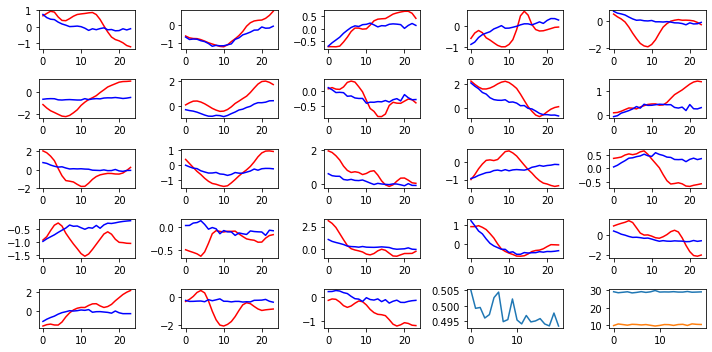

Step: 0, Train Loss: 0.38801121711730957
Step: 20, Train Loss: 0.5019783973693848
Step: 40, Train Loss: 0.5192570686340332
Step: 60, Train Loss: 0.43017587065696716
Step: 80, Train Loss: 0.5269185900688171
Step: 100, Train Loss: 0.3245745301246643
Step: 120, Train Loss: 0.510365903377533
Step: 140, Train Loss: 0.8690170049667358
Epoch: 21, Train loss: 0.49573211215592766
acskill_socre:45.488703823501496, rmse_score:16.167221775453694
acskill_socre:27.290928849604086, rmse_score:17.197675124297852
Epoch: 21, Valid Score: 29.321482048047802, Valid Score 2: 10.093253725306234



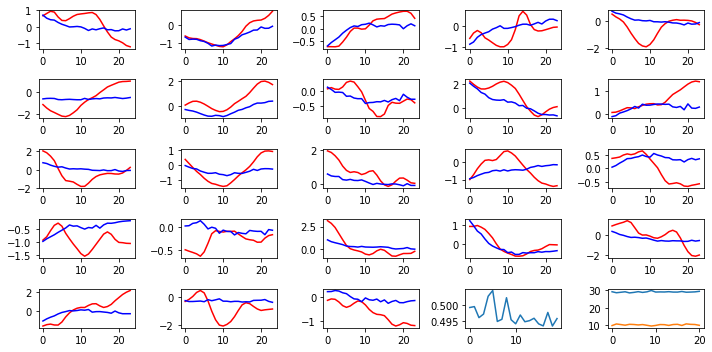

Step: 0, Train Loss: 0.549461841583252
Step: 20, Train Loss: 0.5435935258865356
Step: 40, Train Loss: 0.5132666826248169
Step: 60, Train Loss: 0.43557971715927124
Step: 80, Train Loss: 0.3422122895717621
Step: 100, Train Loss: 0.4325178563594818
Step: 120, Train Loss: 0.4913862943649292
Step: 140, Train Loss: 0.43627870082855225
Epoch: 22, Train loss: 0.4946732189688649
acskill_socre:44.85935066883833, rmse_score:16.193407936069445
acskill_socre:27.694916074673195, rmse_score:17.12326017304679
Epoch: 22, Valid Score: 28.665942732768887, Valid Score 2: 10.571655901626404



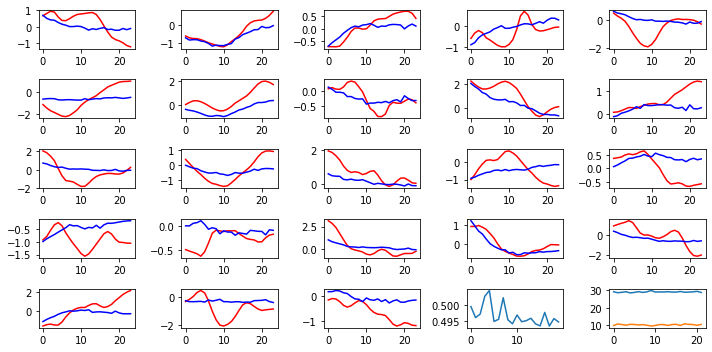

Step: 0, Train Loss: 0.482976496219635
Step: 20, Train Loss: 0.4329507052898407
Step: 40, Train Loss: 0.4003314673900604
Step: 60, Train Loss: 0.5170220136642456
Step: 80, Train Loss: 0.31946128606796265
Step: 100, Train Loss: 0.5654017925262451
Step: 120, Train Loss: 0.4274604320526123
Step: 140, Train Loss: 0.4926601052284241
Epoch: 23, Train loss: 0.49692464479199655
acskill_socre:44.765992479330535, rmse_score:16.41759739409878
acskill_socre:27.91101051600126, rmse_score:17.136839885652634
Epoch: 23, Valid Score: 28.348395085231754, Valid Score 2: 10.774170630348625



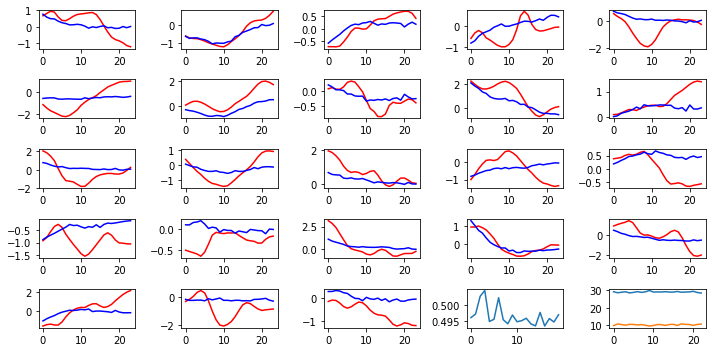

Step: 0, Train Loss: 0.4310133457183838
Step: 20, Train Loss: 0.44876739382743835
Step: 40, Train Loss: 0.3986498713493347
Step: 60, Train Loss: 0.4147002398967743
Step: 80, Train Loss: 0.4020662307739258
Step: 100, Train Loss: 0.5020996928215027
Step: 120, Train Loss: 0.5238466262817383
Step: 140, Train Loss: 0.501713216304779
Epoch: 24, Train loss: 0.4939247974148997
acskill_socre:45.75969224754732, rmse_score:16.132658224007496
acskill_socre:27.257339641703417, rmse_score:17.177752140963968
Epoch: 24, Valid Score: 29.627034023539824, Valid Score 2: 10.07958750073945



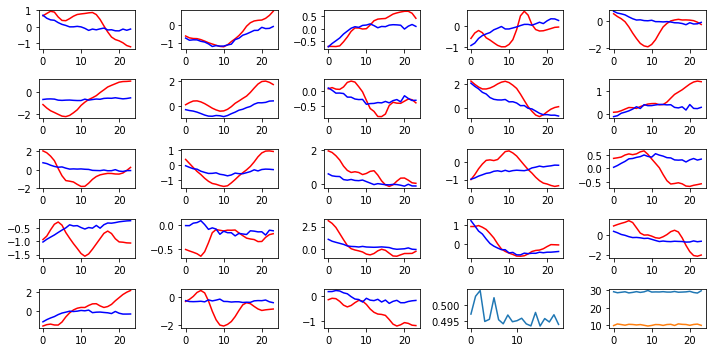

Step: 0, Train Loss: 0.37423333525657654
Step: 20, Train Loss: 0.665409505367279
Step: 40, Train Loss: 0.6394051313400269
Step: 60, Train Loss: 0.43172430992126465
Step: 80, Train Loss: 0.4996897876262665
Step: 100, Train Loss: 0.5355748534202576
Step: 120, Train Loss: 0.4631178081035614
Step: 140, Train Loss: 0.3904968202114105
Epoch: 25, Train loss: 0.4951183958487077
acskill_socre:45.072682280485495, rmse_score:16.232320749383664
acskill_socre:27.909154749746342, rmse_score:17.10290569102052
Epoch: 25, Valid Score: 28.84036153110183, Valid Score 2: 10.806249058725822



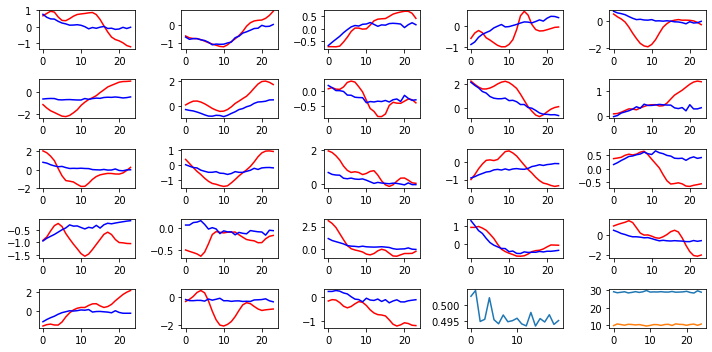

Step: 0, Train Loss: 0.5418652892112732
Step: 20, Train Loss: 0.39340740442276
Step: 40, Train Loss: 0.41036170721054077
Step: 60, Train Loss: 0.6327618360519409
Step: 80, Train Loss: 0.5343708395957947
Step: 100, Train Loss: 0.5086030960083008
Step: 120, Train Loss: 0.45574110746383667
Step: 140, Train Loss: 0.45847171545028687
Epoch: 26, Train loss: 0.49284276699686386
acskill_socre:44.52198700637305, rmse_score:16.232145287074438
acskill_socre:28.087632295219212, rmse_score:17.070582637753514
Epoch: 26, Valid Score: 28.289841719298614, Valid Score 2: 11.017049657465698



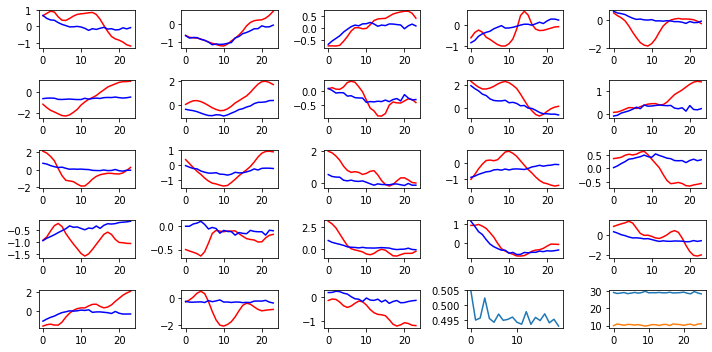

Step: 0, Train Loss: 0.34298771619796753
Step: 20, Train Loss: 0.5274060964584351
Step: 40, Train Loss: 0.4845118522644043
Step: 60, Train Loss: 0.7890805006027222
Step: 80, Train Loss: 0.6104325652122498
Step: 100, Train Loss: 0.5789512395858765
Step: 120, Train Loss: 0.4277492165565491
Step: 140, Train Loss: 0.36438506841659546
Epoch: 27, Train loss: 0.49310369008070937
acskill_socre:45.15304275031841, rmse_score:16.175043980852134
acskill_socre:27.816149593415354, rmse_score:17.09458193997015
Epoch: 27, Valid Score: 28.97799876946628, Valid Score 2: 10.721567653445202



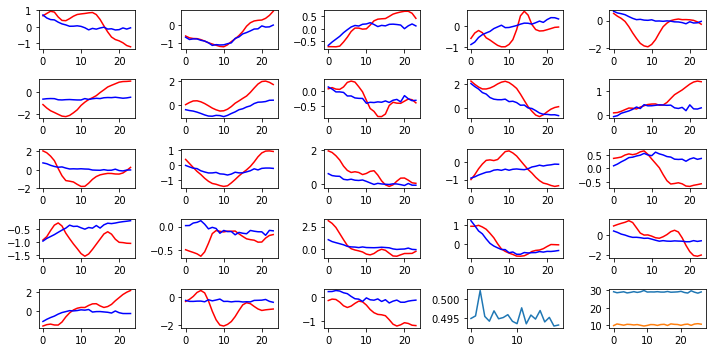

Step: 0, Train Loss: 0.5463898777961731
Step: 20, Train Loss: 0.40181034803390503
Step: 40, Train Loss: 0.45362409949302673
Step: 60, Train Loss: 0.6028421521186829
Step: 80, Train Loss: 0.5179471969604492
Step: 100, Train Loss: 0.5975466966629028
Step: 120, Train Loss: 0.6272714138031006
Step: 140, Train Loss: 0.4993430972099304
Epoch: 28, Train loss: 0.4913809471405469
acskill_socre:45.69248399907252, rmse_score:16.117600670624544
acskill_socre:27.572472586295284, rmse_score:17.12167175356028
Epoch: 28, Valid Score: 29.574883328447978, Valid Score 2: 10.450800832735005



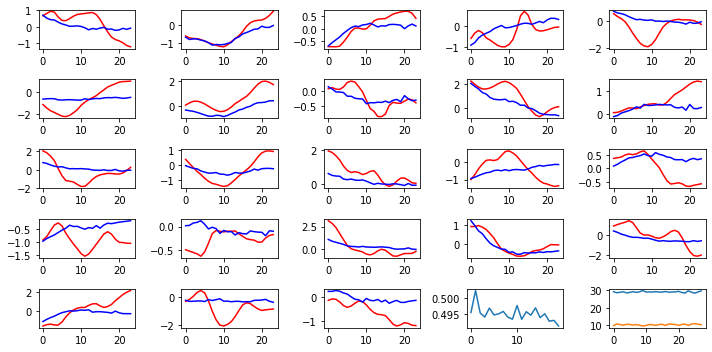

Step: 0, Train Loss: 0.5873703956604004
Step: 20, Train Loss: 0.4821317791938782
Step: 40, Train Loss: 0.36785802245140076
Step: 60, Train Loss: 0.6703485250473022
Step: 80, Train Loss: 0.5959783792495728
Step: 100, Train Loss: 0.38300150632858276
Step: 120, Train Loss: 0.33567842841148376
Step: 140, Train Loss: 0.6508446931838989
Epoch: 29, Train loss: 0.4930603210325841
acskill_socre:45.98736330244271, rmse_score:16.129373765214112
acskill_socre:27.379574684117973, rmse_score:17.191743380268637
Epoch: 29, Valid Score: 29.857989537228597, Valid Score 2: 10.187831303849336

Model saved successfully


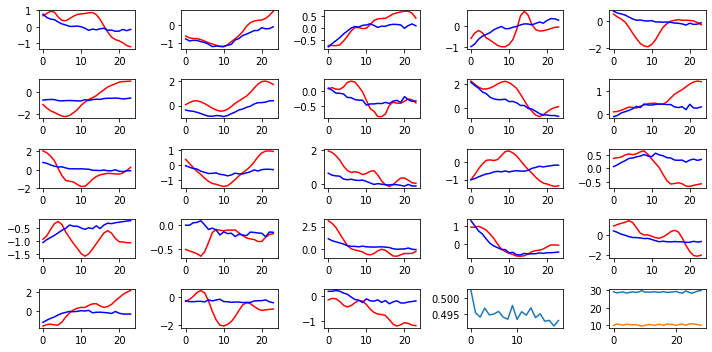

Step: 0, Train Loss: 0.39489656686782837
Step: 20, Train Loss: 0.3888547420501709
Step: 40, Train Loss: 0.42142194509506226
Step: 60, Train Loss: 0.8125100135803223
Step: 80, Train Loss: 0.6383251547813416
Step: 100, Train Loss: 0.6175134181976318
Step: 120, Train Loss: 0.584958553314209
Step: 140, Train Loss: 0.4514002799987793
Epoch: 30, Train loss: 0.49489873626849035
acskill_socre:46.0670778190987, rmse_score:16.09453580411886
acskill_socre:27.14544922718614, rmse_score:17.226043159022183
Epoch: 30, Valid Score: 29.97254201497984, Valid Score 2: 9.919406068163958

Model saved successfully


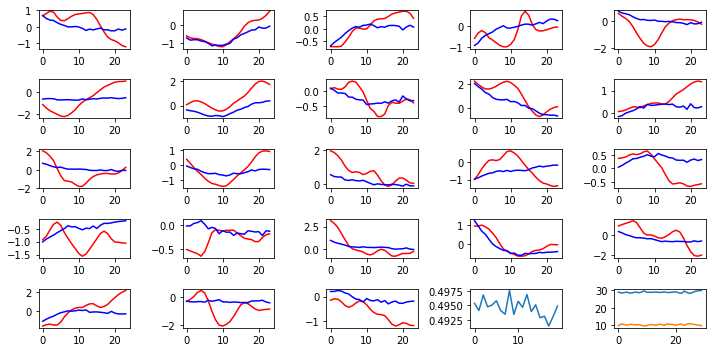

Step: 0, Train Loss: 0.511094868183136
Step: 20, Train Loss: 0.5557256937026978
Step: 40, Train Loss: 0.6830255389213562
Step: 60, Train Loss: 0.5077825784683228
Step: 80, Train Loss: 0.3188548982143402
Step: 100, Train Loss: 0.36996328830718994
Step: 120, Train Loss: 0.39625298976898193
Step: 140, Train Loss: 0.5274512767791748
Epoch: 31, Train loss: 0.49614401255454216
acskill_socre:45.550717068180916, rmse_score:16.292782094540854
acskill_socre:27.496406901588234, rmse_score:17.21679126588768
Epoch: 31, Valid Score: 29.25793497364006, Valid Score 2: 10.279615635700555



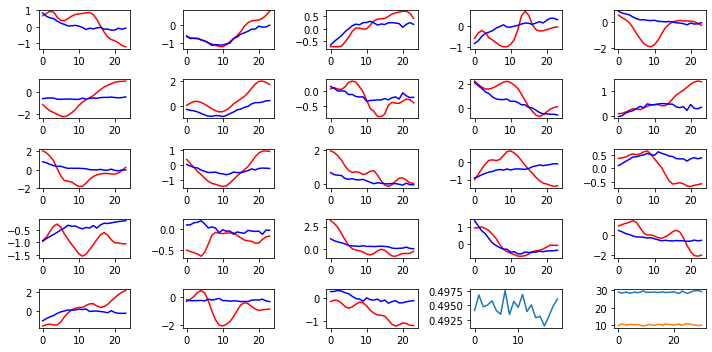

Step: 0, Train Loss: 0.49863409996032715
Step: 20, Train Loss: 0.33991557359695435
Step: 40, Train Loss: 0.30215704441070557
Step: 60, Train Loss: 0.6079410910606384
Step: 80, Train Loss: 0.3551402986049652
Step: 100, Train Loss: 0.4727829098701477
Step: 120, Train Loss: 0.5492427945137024
Step: 140, Train Loss: 0.33371400833129883
Epoch: 32, Train loss: 0.4915812196327256
acskill_socre:45.36375654523437, rmse_score:16.275157792218742
acskill_socre:27.8433439593286, rmse_score:17.15794860725069
Epoch: 32, Valid Score: 29.088598753015624, Valid Score 2: 10.685395352077908



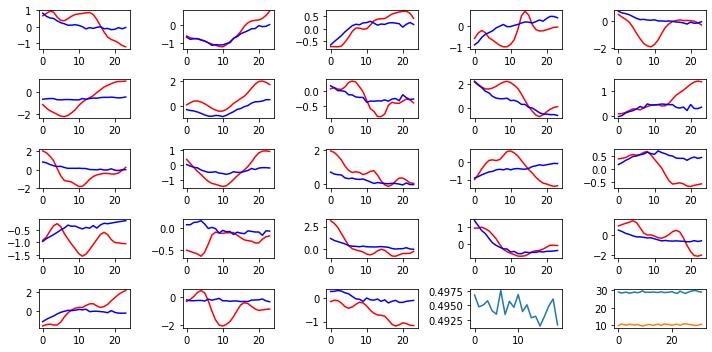

Step: 0, Train Loss: 0.43003231287002563
Step: 20, Train Loss: 0.44475626945495605
Step: 40, Train Loss: 0.40258535742759705
Step: 60, Train Loss: 0.38686618208885193
Step: 80, Train Loss: 0.5147805213928223
Step: 100, Train Loss: 0.5554406642913818
Step: 120, Train Loss: 0.48211246728897095
Step: 140, Train Loss: 0.39273184537887573
Epoch: 33, Train loss: 0.4955252907076082
acskill_socre:45.602626562077816, rmse_score:16.189795325153572
acskill_socre:27.43954839584334, rmse_score:17.169794013374784
Epoch: 33, Valid Score: 29.412831236924244, Valid Score 2: 10.269754382468555



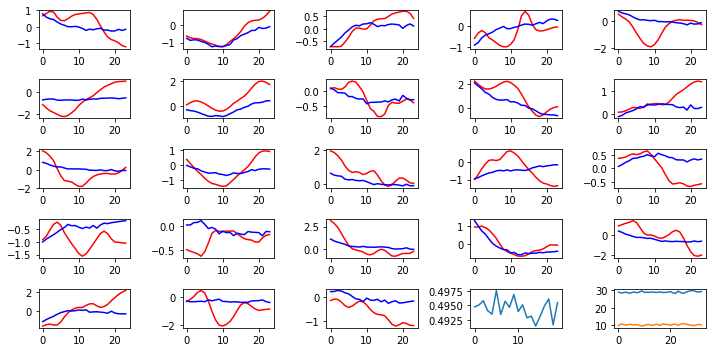

Step: 0, Train Loss: 0.5417600870132446
Step: 20, Train Loss: 0.42163270711898804
Step: 40, Train Loss: 0.42235061526298523
Step: 60, Train Loss: 0.662651777267456
Step: 80, Train Loss: 0.386688232421875
Step: 100, Train Loss: 0.42841559648513794
Step: 120, Train Loss: 0.5278114676475525
Step: 140, Train Loss: 0.28515973687171936
Epoch: 34, Train loss: 0.49189621105894343
acskill_socre:46.054140473403926, rmse_score:16.200445318652214
acskill_socre:27.340301133748, rmse_score:17.213189412135527
Epoch: 34, Valid Score: 29.853695154751712, Valid Score 2: 10.127111721612472



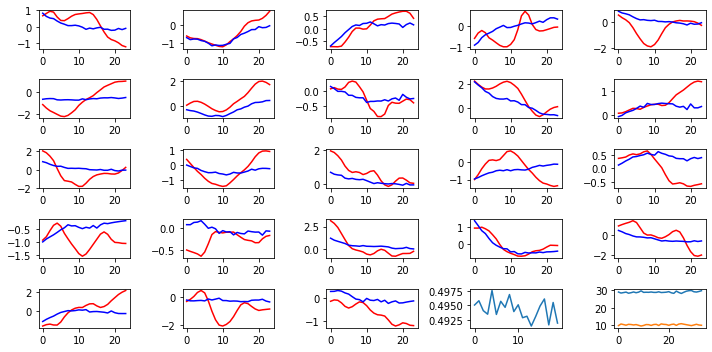

Step: 0, Train Loss: 0.46729743480682373
Step: 20, Train Loss: 0.3504104018211365
Step: 40, Train Loss: 0.374933123588562
Step: 60, Train Loss: 0.49772781133651733
Step: 80, Train Loss: 0.5693503022193909
Step: 100, Train Loss: 0.6438695192337036
Step: 120, Train Loss: 0.35367506742477417
Step: 140, Train Loss: 0.48475250601768494
Epoch: 35, Train loss: 0.49167518744935523
acskill_socre:45.90088086163062, rmse_score:16.1409821649117
acskill_socre:27.420430151888837, rmse_score:17.167481877013902
Epoch: 35, Valid Score: 29.759898696718917, Valid Score 2: 10.252948274874935



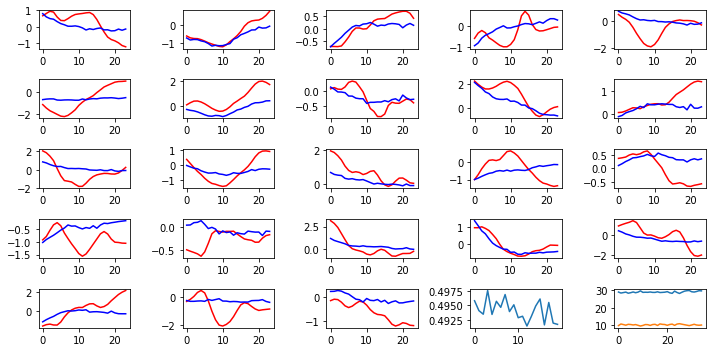

Step: 0, Train Loss: 0.35999685525894165
Step: 20, Train Loss: 0.4760887026786804
Step: 40, Train Loss: 0.5697065591812134
Step: 60, Train Loss: 0.3858336806297302
Step: 80, Train Loss: 0.5156371593475342
Step: 100, Train Loss: 0.3546871542930603
Step: 120, Train Loss: 0.3607981204986572
Step: 140, Train Loss: 0.6620530486106873
Epoch: 36, Train loss: 0.49492413576666294
acskill_socre:45.34255656210094, rmse_score:16.230686869700865
acskill_socre:27.623792179033476, rmse_score:17.1128829069256
Epoch: 36, Valid Score: 29.111869692400074, Valid Score 2: 10.510909272107877



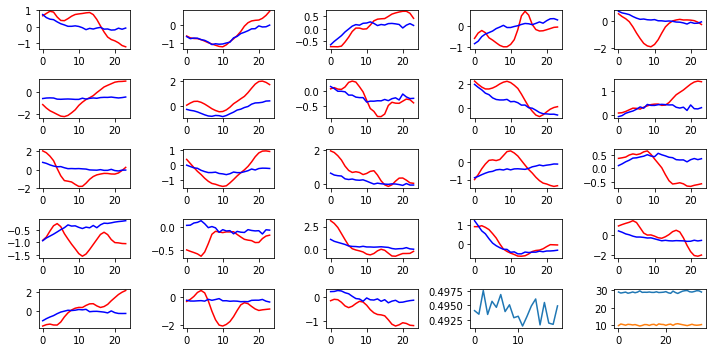

Step: 0, Train Loss: 0.44519346952438354
Step: 20, Train Loss: 0.28949272632598877
Step: 40, Train Loss: 0.4586760401725769
Step: 60, Train Loss: 0.3442116677761078
Step: 80, Train Loss: 0.4289422035217285
Step: 100, Train Loss: 0.7078757286071777
Step: 120, Train Loss: 0.3392854630947113
Step: 140, Train Loss: 0.6720255613327026
Epoch: 37, Train loss: 0.4919419096900033
acskill_socre:46.03753623767592, rmse_score:16.130680488441232
acskill_socre:27.19825231690062, rmse_score:17.255513486917067
Epoch: 37, Valid Score: 29.90685574923469, Valid Score 2: 9.942738829983554



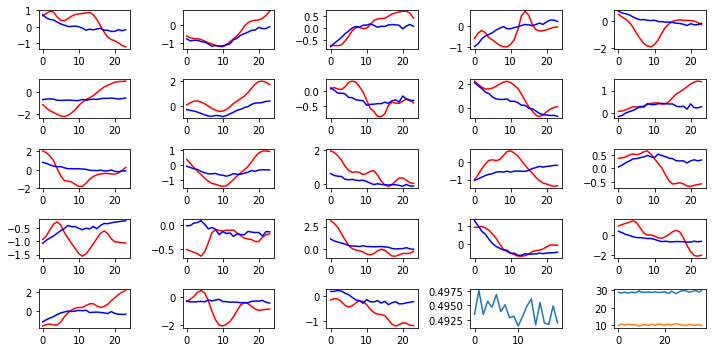

Step: 0, Train Loss: 0.45486944913864136
Step: 20, Train Loss: 0.45313701033592224
Step: 40, Train Loss: 0.45330139994621277
Step: 60, Train Loss: 0.8709627985954285
Step: 80, Train Loss: 0.3927028179168701
Step: 100, Train Loss: 0.4854762554168701
Step: 120, Train Loss: 0.5483801364898682
Step: 140, Train Loss: 0.5898393988609314
Epoch: 38, Train loss: 0.4942989968336545
acskill_socre:45.56436501570508, rmse_score:16.157265853628427
acskill_socre:27.575862844099692, rmse_score:17.169762698896633
Epoch: 38, Valid Score: 29.40709916207665, Valid Score 2: 10.406100145203059



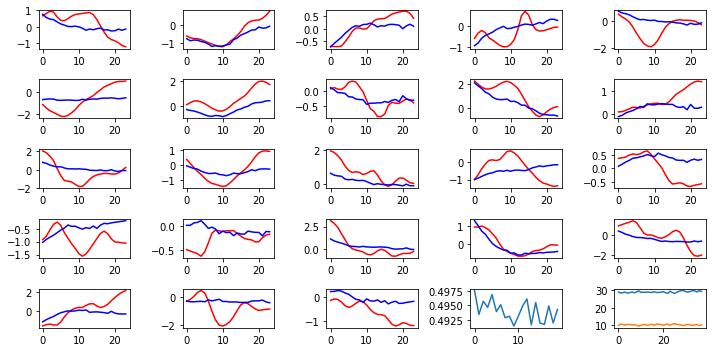

Step: 0, Train Loss: 0.4060457646846771
Step: 20, Train Loss: 0.5819941163063049
Step: 40, Train Loss: 0.6209214925765991
Step: 60, Train Loss: 0.4032023847103119
Step: 80, Train Loss: 0.4515398144721985
Step: 100, Train Loss: 0.5162070989608765
Step: 120, Train Loss: 0.5026901364326477
Step: 140, Train Loss: 0.5011928081512451
Epoch: 39, Train loss: 0.491538104790074
acskill_socre:45.89023340780807, rmse_score:16.14001676442166
acskill_socre:27.385629823686095, rmse_score:17.193126983610902
Epoch: 39, Valid Score: 29.75021664338641, Valid Score 2: 10.192502840075193



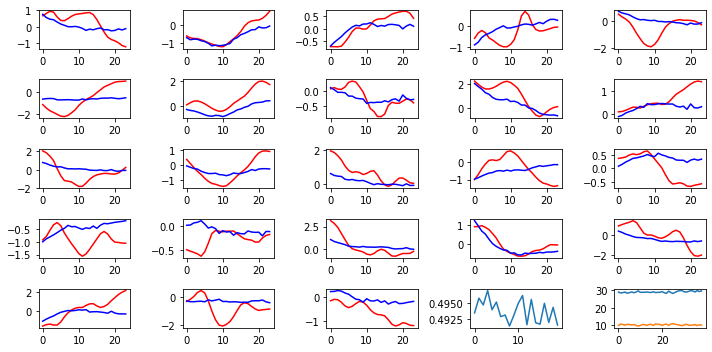

Step: 0, Train Loss: 0.4410228729248047
Step: 20, Train Loss: 0.4279475212097168
Step: 40, Train Loss: 0.4620065689086914
Step: 60, Train Loss: 0.532021701335907
Step: 80, Train Loss: 0.38630008697509766
Step: 100, Train Loss: 0.5169274210929871
Step: 120, Train Loss: 0.3965393900871277
Step: 140, Train Loss: 0.5233104825019836
Epoch: 40, Train loss: 0.4951176451636361
acskill_socre:46.32255798757413, rmse_score:16.177763468748147
acskill_socre:26.817977891575275, rmse_score:17.28515493029433
Epoch: 40, Valid Score: 30.144794518825982, Valid Score 2: 9.532822961280946

Model saved successfully


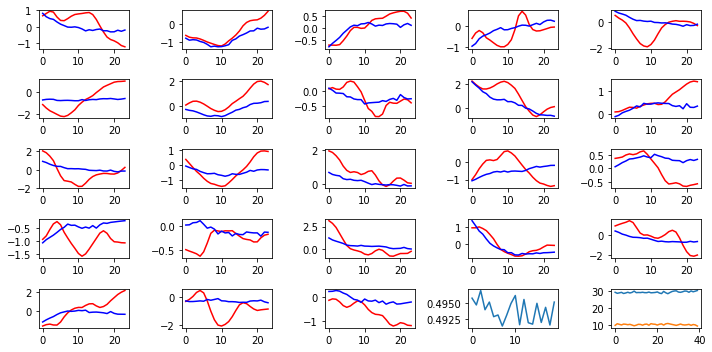

Step: 0, Train Loss: 0.5282647013664246
Step: 20, Train Loss: 0.392686128616333
Step: 40, Train Loss: 1.0664386749267578
Step: 60, Train Loss: 0.5016422271728516
Step: 80, Train Loss: 0.570354163646698
Step: 100, Train Loss: 0.6708194017410278
Step: 120, Train Loss: 0.4412864148616791
Step: 140, Train Loss: 0.6505597829818726
Epoch: 41, Train loss: 0.4924057815875207
acskill_socre:45.783941136076265, rmse_score:16.16979464427562
acskill_socre:27.35540675106957, rmse_score:17.197096703549555
Epoch: 41, Valid Score: 29.614146491800646, Valid Score 2: 10.158310047520015



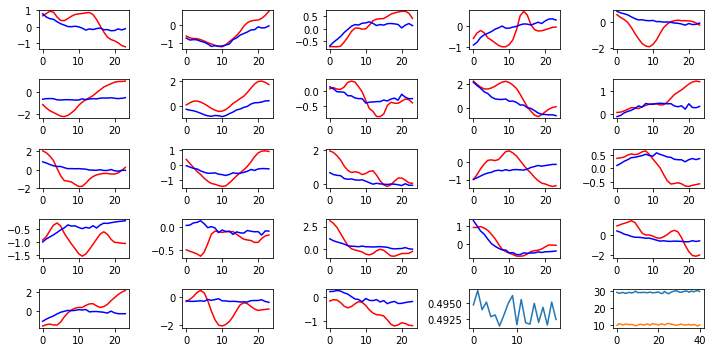

Step: 0, Train Loss: 0.4586075246334076
Step: 20, Train Loss: 0.4981991946697235
Step: 40, Train Loss: 0.4084796905517578
Step: 60, Train Loss: 0.4515940845012665
Step: 80, Train Loss: 0.5865875482559204
Step: 100, Train Loss: 0.4574980139732361
Step: 120, Train Loss: 0.4720099866390228
Step: 140, Train Loss: 0.5153722763061523
Epoch: 42, Train loss: 0.4923423516166794
acskill_socre:45.64349540295928, rmse_score:16.110011913470412
acskill_socre:27.621034716945978, rmse_score:17.13851542956906
Epoch: 42, Valid Score: 29.53348348948887, Valid Score 2: 10.482519287376917



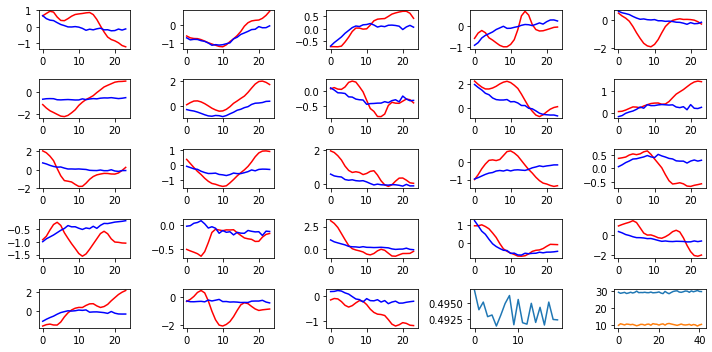

Step: 0, Train Loss: 0.33208799362182617
Step: 20, Train Loss: 0.4659338891506195
Step: 40, Train Loss: 0.3651391863822937
Step: 60, Train Loss: 0.5577722191810608
Step: 80, Train Loss: 0.41552573442459106
Step: 100, Train Loss: 0.5170273780822754
Step: 120, Train Loss: 0.6198192834854126
Step: 140, Train Loss: 0.5078417062759399
Epoch: 43, Train loss: 0.49108588924774754
acskill_socre:45.35517797102486, rmse_score:16.14158543614675
acskill_socre:27.672784107758794, rmse_score:17.12769817708068
Epoch: 43, Valid Score: 29.213592534878106, Valid Score 2: 10.545085930678113



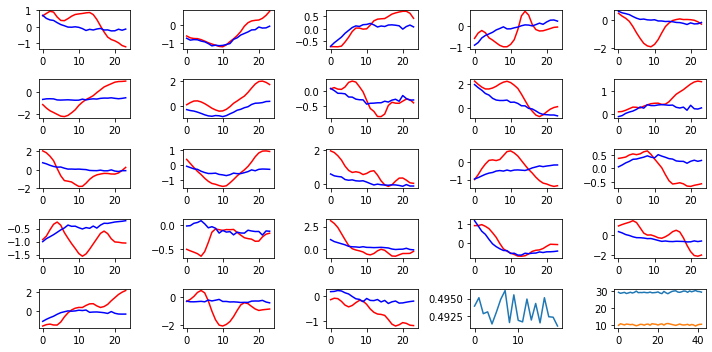

Step: 0, Train Loss: 0.5441862344741821
Step: 20, Train Loss: 0.45325252413749695
Step: 40, Train Loss: 0.34296903014183044
Step: 60, Train Loss: 0.5001472234725952
Step: 80, Train Loss: 0.5268235206604004
Step: 100, Train Loss: 0.34085631370544434
Step: 120, Train Loss: 0.502644956111908
Step: 140, Train Loss: 0.42844313383102417
Epoch: 44, Train loss: 0.4909375587126592
acskill_socre:46.053862605744555, rmse_score:16.108715955683586
acskill_socre:27.322624662891673, rmse_score:17.18527463480784
Epoch: 44, Valid Score: 29.94514665006097, Valid Score 2: 10.137350028083834



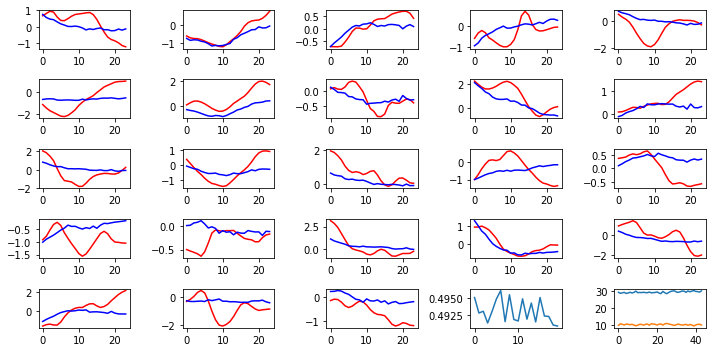

Step: 0, Train Loss: 0.4545717239379883
Step: 20, Train Loss: 0.5381545424461365
Step: 40, Train Loss: 0.6579927206039429
Step: 60, Train Loss: 0.6305461525917053
Step: 80, Train Loss: 0.5440086722373962
Step: 100, Train Loss: 0.4849655330181122
Step: 120, Train Loss: 0.4668809771537781
Step: 140, Train Loss: 0.4619201123714447
Epoch: 45, Train loss: 0.49426071647997505
acskill_socre:45.98886939863401, rmse_score:16.133699822525944
acskill_socre:27.244792356251544, rmse_score:17.203486785994517
Epoch: 45, Valid Score: 29.855169576108064, Valid Score 2: 10.041305570257027



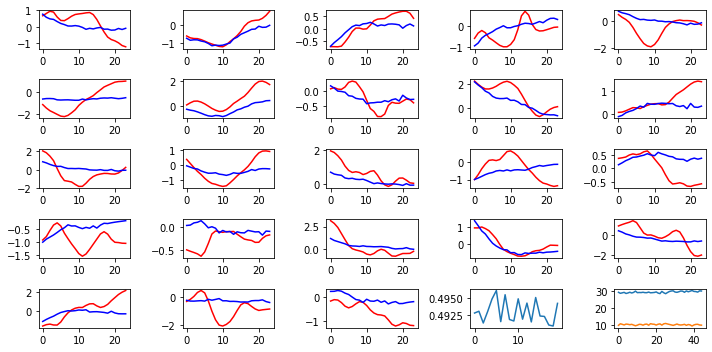

Step: 0, Train Loss: 0.4426043927669525
Step: 20, Train Loss: 0.4157997965812683
Step: 40, Train Loss: 0.58829265832901
Step: 60, Train Loss: 0.4151977300643921
Step: 80, Train Loss: 0.5564495325088501
Step: 100, Train Loss: 0.3940260410308838
Step: 120, Train Loss: 0.3847523629665375
Step: 140, Train Loss: 0.41604480147361755
Epoch: 46, Train loss: 0.4913489810236684
acskill_socre:45.50849206618423, rmse_score:16.19752998777514
acskill_socre:27.69206739627018, rmse_score:17.12000554134281
Epoch: 46, Valid Score: 29.31096207840909, Valid Score 2: 10.57206185492737



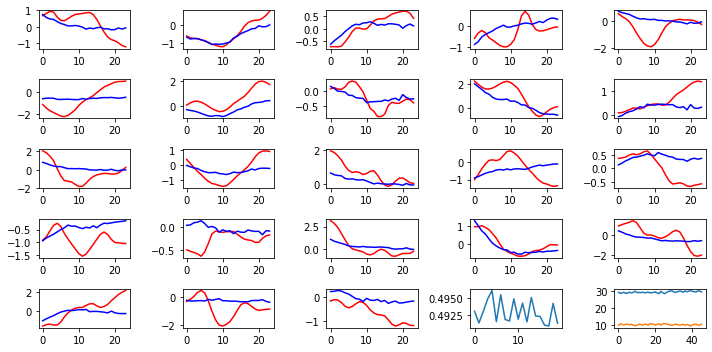

Step: 0, Train Loss: 0.4462850093841553
Step: 20, Train Loss: 0.39734238386154175
Step: 40, Train Loss: 0.4059585928916931
Step: 60, Train Loss: 0.5147061347961426
Step: 80, Train Loss: 0.43887394666671753
Step: 100, Train Loss: 0.519727349281311
Step: 120, Train Loss: 0.3944395184516907
Step: 140, Train Loss: 0.3919920325279236
Epoch: 47, Train loss: 0.49545933879338777
acskill_socre:45.46530549223096, rmse_score:16.151269707204804
acskill_socre:27.816165718449454, rmse_score:17.103231878246437
Epoch: 47, Valid Score: 29.314035785026157, Valid Score 2: 10.712933840203018



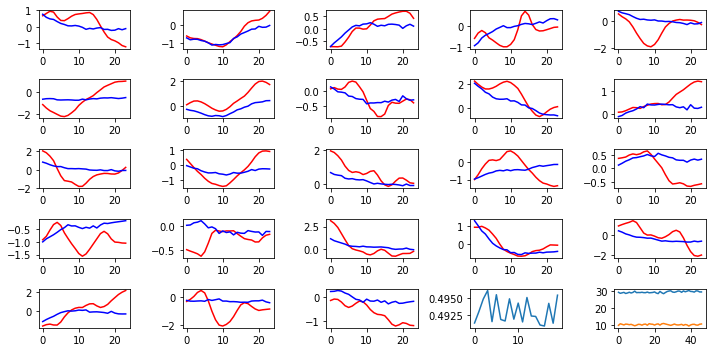

Step: 0, Train Loss: 0.7623696327209473
Step: 20, Train Loss: 0.32611846923828125
Step: 40, Train Loss: 0.5332848429679871
Step: 60, Train Loss: 0.45664867758750916
Step: 80, Train Loss: 0.43774545192718506
Step: 100, Train Loss: 0.46102333068847656
Step: 120, Train Loss: 0.4078868329524994
Step: 140, Train Loss: 0.43956395983695984
Epoch: 48, Train loss: 0.5310403783838232
acskill_socre:46.25635582889349, rmse_score:16.09309140284429
acskill_socre:27.06914346221719, rmse_score:17.24560212497813
Epoch: 48, Valid Score: 30.1632644260492, Valid Score 2: 9.82354133723906

Model saved successfully


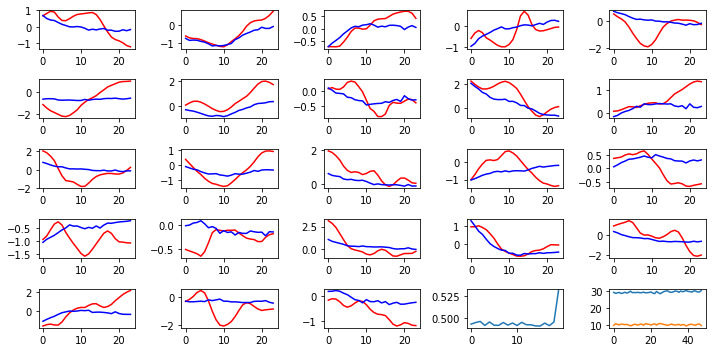

Step: 0, Train Loss: 0.5321516990661621
Step: 20, Train Loss: 0.527944803237915
Step: 40, Train Loss: 0.46469998359680176
Step: 60, Train Loss: 0.6877079010009766
Step: 80, Train Loss: 0.5258216261863708
Step: 100, Train Loss: 0.5331283807754517
Step: 120, Train Loss: 0.5847277045249939
Step: 140, Train Loss: 0.49990496039390564
Epoch: 49, Train loss: 0.4906492816818344
acskill_socre:45.239225834204746, rmse_score:16.146871975061828
acskill_socre:28.21724319873822, rmse_score:17.065358522135696
Epoch: 49, Valid Score: 29.092353859142918, Valid Score 2: 11.151884676602524



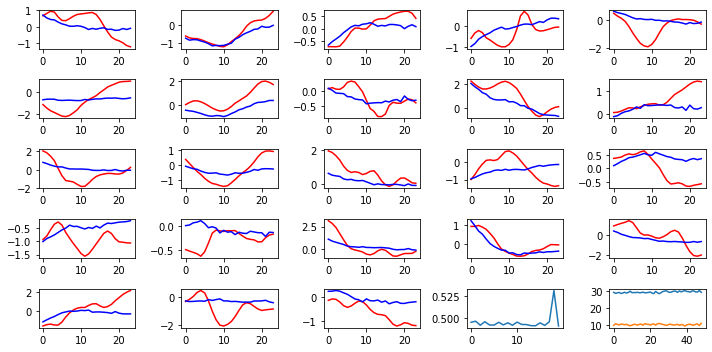

Step: 0, Train Loss: 0.35619521141052246
Step: 20, Train Loss: 0.48578381538391113
Step: 40, Train Loss: 0.3728122115135193
Step: 60, Train Loss: 0.5162675380706787
Step: 80, Train Loss: 0.40205618739128113
Step: 100, Train Loss: 0.5699158310890198
Step: 120, Train Loss: 0.6145713329315186
Step: 140, Train Loss: 0.43727368116378784
Epoch: 50, Train loss: 0.4930938398921406
acskill_socre:46.36125581661834, rmse_score:16.13588622542351
acskill_socre:27.26569397131312, rmse_score:17.23861418765718
Epoch: 50, Valid Score: 30.22536959119483, Valid Score 2: 10.027079783655939

Model saved successfully


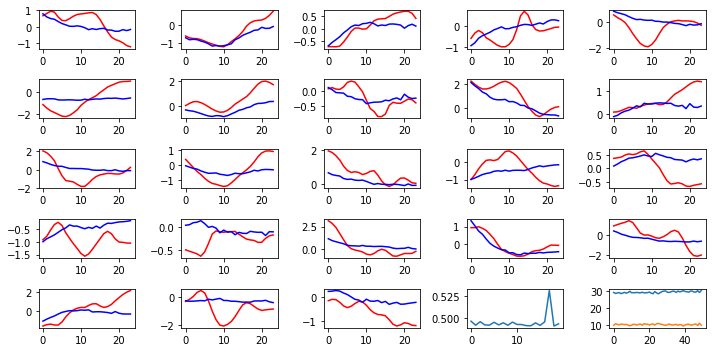

max score: 30.22536959119483 at eopch 50
max score 2: 11.151884676602524 at eopch 49


In [30]:
train(num_epochs=50)

In [25]:
# model.load_state_dict(torch.load('models/basemodel_best.pt'))

In [ ]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [ ]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
#     data_list = [SST,T300,Ua,Va]
#     SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

In [ ]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [ ]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [ ]:
make_zip()